In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, N3, JSON
from rdflib import Graph
import plotly.graph_objects as go
import plotly.express as px
import re

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 5)

%matplotlib inline

## Load the data frame

In [2]:
#Read query results from CSV file
get_ratio_df_all_per_global = pd.read_csv("get_ratio_df_all_per_global1.csv")

#drop first column
get_ratio_df_all_per_global = get_ratio_df_all_per_global.drop(['Unnamed: 0'], axis=1)


#change the column to name the facets of the plot
get_ratio_df_all_per_global = get_ratio_df_all_per_global.rename(columns={'merge': 'metricName'})
get_ratio_df_all_per_global['metricName'] = get_ratio_df_all_per_global['metricName'].str.replace('\\','')

get_ratio_df_all_per_global['unique_ds']=get_ratio_df_all_per_global['ds'].astype(str)+', '+get_ratio_df_all_per_global['metricName']
get_ratio_df_all_per_global['unique_task']=get_ratio_df_all_per_global['task'].astype(str)+', '+get_ratio_df_all_per_global['metricName']

get_ratio_df_all_per_global['unique_task_ds_metric']=get_ratio_df_all_per_global['task'].astype(str)+', '+get_ratio_df_all_per_global['ds'].astype(str)+', '+get_ratio_df_all_per_global['metricName']

#plot unique metricName
pd.DataFrame(get_ratio_df_all_per_global["metricName"].unique())

<ipython-input-2-94029eaf80b0>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  get_ratio_df_all_per_global['metricName'] = get_ratio_df_all_per_global['metricName'].str.replace('\\','')


0
0    1 in 10 R-at-1
1                F1
..              ...
174              DE
175              BA

[176 rows x 1 columns]

## Prepare the data frame

In [3]:
#calculate average data frame using 'RATIO' as criteria FOR unique_task
#This graph is fine, however, it will display overlapped datasets used for the same task in the same trajectory.
traj = get_ratio_df_all_per_global.copy()

#task causing some problems
traj = traj.drop(traj[traj["metricName"]=="Parameters"].index)
#traj = traj.drop(traj[traj["unique_task"]=="Natural Language Inference, Parameters"].index)

#Process date field
#traj["date"]=pd.to_datetime(traj["date"]).dt.year

#traj["date"] = pd.to_datetime(traj["date"]).dt.strftime('%Y-%m')


In [4]:
#This will drop cases where the single points that represents ratio = 100%.
traj = traj.drop(traj[traj["ratio"]==1].index)

In [5]:
#this will delete from the traj data frame, all the ds/tasks which the counts are equal to 1
#pd.set_option("display.max_rows", None)
count_df = pd.DataFrame(traj['ds'].value_counts())
count_df[count_df.ds==1].index
traj = traj[~traj['ds'].isin(count_df[count_df.ds==1].index)]


count_df = pd.DataFrame(traj['task'].value_counts())
count_df[count_df.task==1].index
traj = traj[~traj['task'].isin(count_df[count_df.task==1].index)]

pd.DataFrame(traj['ds'].value_counts())

ds
CNN / Daily Mail                47
SemEval 2014 Task 4 Sub Task 2  30
...                             ..
Classic                          2
_Restricted_                     2

[192 rows x 1 columns]

## Plot using Ratio for Task

In [6]:
#I removed the white dots from this plot. Search for [add white dots] above to include them
def add_white(category):
    fig.add_trace(go.Scatter(
            x = average_summary_OUT["date"],
            y = average_summary_OUT[category],
            mode='markers',
            name=None,
            marker=dict(
                size=10, 
                color="white",
                #opacity=0.5,
                ),
            hovertemplate=average_summary_OUT[category]+
                  "<BR>category: "+ average_summary_OUT[category]+
                  "<BR>date: "+ average_summary_OUT["date"].astype("string")+
                  "<BR>ratio: "+ average_summary_OUT["ratio"].astype("string"),
    
        ))
    

In [7]:
#variable_to_plot = "ratio"
#choose here which grouping variable to use
average_summary = pd.DataFrame(traj.groupby(['task','date'])['ratio'].mean())

average_summary.sort_values(by=['date'], ascending=True)

average_summary.reset_index(inplace=True)  
#average_summary["date"]=pd.to_datetime(average_summary['date'])
#average_summary["date"]=average_summary["date"].dt.year
average_summary["in_trajectory"]=1


i=0
for t in average_summary.task.unique():
    sota_per = 0
    #here the date can't be unique, because we want to look for the best value per year
    for v in average_summary[average_summary["task"]==t].ratio:
        per = average_summary[(average_summary["task"]==t)&(average_summary["ratio"]==v)].ratio.astype(float)
        per = per.iloc[0]
        if(per >= sota_per):
            #print(per)
            sota_per = per
            average_summary.loc[i,"in_trajectory"]= "IN"
        else:
            #average_summary = average_summary.drop(i)
            average_summary.loc[i,"in_trajectory"]= "IN"  #change back to OUT 
            #sota_per = per
        i = i+1         

#Add OUT to high gain values, normally those of the first results. They will be displayed as white dots.
average_summary.loc[average_summary['ratio'] > 0.5, 'in_trajectory'] = "OUT"
        
average_summary['ratio'] = average_summary['ratio'].apply(lambda x: round(x, 2))        
#average_summary = average_summary.rename(columns={'gain': 'gain'})

#needs to rename here to average of percentage of maximum sota


###NOW PLOT IT
#try using plotly
import pandas as pd
import plotly.express as px
from plotly.validators.scatter.marker import SymbolValidator
average_summary_IN = average_summary[average_summary["in_trajectory"]=="IN"]
average_summary_OUT = average_summary[average_summary["in_trajectory"]=="OUT"]

fig = px.line(average_summary_IN, x='date' , y='task' , color='task')

#this trace adds first all the dates with a data point attached to it
#fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
#fig3_df["date"]=pd.to_datetime(fig3_df['date'])
#fig3_df["date"]=fig3_df["date"].dt.year


        
#then as use the average_summary df to add only the data that forms a trajectory#
#this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

add_white("task")

fig.add_trace(go.Scatter(
    x = average_summary_IN["date"],
    y = average_summary_IN["task"],
    mode='markers',
    name=None,
    hovertemplate=average_summary_IN["task"]+
                  "<BR>task: "+ average_summary_IN["task"]+
                  "<BR>date: "+ average_summary_IN["date"].astype("string")+
                  "<BR>ratio: "+ average_summary_IN["ratio"].astype("string"),
    marker=dict(
        size=15, #alpha ratio
        symbol=48, #https://plotly.com/python/marker-style/
        opacity=1, #alpha ratio
        color=average_summary_IN["ratio"], #set color equal to a variable
        colorscale='YlGn', # one of plotly colorscales
        colorbar=dict(title='ratio', lenmode="pixels"),
        showscale=True
    )
))


fig.update_traces(marker=dict(line=dict(color='black',width=1)),
                  line=dict(width=1, color="black"),
                 )

fig.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig.update_layout(title="Trajectory for ratio (task per year)", 
                  showlegend=False,
                  plot_bgcolor='white',
                  height=2000,
                  width=900,
                  xaxis = dict(
                    tickmode = 'auto',
                    )
                 ) # set the background colour)

#fig.update_layout(margin_pad=1)
fig.show()

In [8]:
average_summary_IN

task     date  ratio in_trajectory
1    Abstractive Text Summarization  2019-05   0.40            IN
2    Abstractive Text Summarization  2019-12   0.03            IN
..                              ...      ...    ...           ...
479       Word Sense Disambiguation  2019-05   0.08            IN
480       Word Sense Disambiguation  2019-09   0.11            IN

[359 rows x 4 columns]

In [10]:
#This block will take the values from average_summary_IN and delete those that have only one arrow per category
count_df = pd.DataFrame(average_summary_IN['task'].value_counts())
count_df[count_df.task==1].index
average_summary_IN = average_summary_IN[~average_summary_IN['task'].isin(count_df[count_df.task==1].index)]
#this will delete from the traj data frame, all the tasks which the average_summary_IN counts are equal to 1
#meaning single arrows will be excluded from the plot

### Same plot as before, but then, only with more than one arrow per trajectory.

In [12]:
fig = px.line(average_summary_IN, x='date' , y='task' , color='task')

#this trace adds first all the dates with a data point attached to it
#fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
#fig3_df["date"]=pd.to_datetime(fig3_df['date'])
#fig3_df["date"]=fig3_df["date"].dt.year


        
#then as use the average_summary df to add only the data that forms a trajectory#
#this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

#This adds/remove those points with value < 1 and > 0.5
#add_white("task")

fig.add_trace(go.Scatter(
    x = average_summary_IN["date"],
    y = average_summary_IN["task"],
    mode='markers',
    name=None,
    hovertemplate=average_summary_IN["task"]+
                  "<BR>task: "+ average_summary_IN["task"]+
                  "<BR>date: "+ average_summary_IN["date"].astype("string")+
                  "<BR>ratio: "+ average_summary_IN["ratio"].astype("string"),
    marker=dict(
        size=15, #alpha ratio
        symbol=48, #https://plotly.com/python/marker-style/
        opacity=0.7, #alpha ratio
        color=average_summary_IN["ratio"], #set color equal to a variable
        colorscale='YlGn', # one of plotly colorscales
        colorbar=dict(title='ratio', lenmode="pixels"),
        showscale=True
    )
))


fig.update_traces(marker=dict(line=dict(color='black',width=1)),
                  line=dict(width=1, color="black"),
                 )

fig.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig.update_layout(title="Trajectory for ratio (task per year)", 
                  showlegend=False,
                  plot_bgcolor='white',
                  height=2000,
                  width=900,
                  xaxis = dict(
                    tickmode = 'auto',
                    )
                 ) # set the background colour)

#fig.update_layout(margin_pad=1)
fig.show()

## Plot using Ratio for unique_task

In [18]:
#variable_to_plot = "ratio"
#choose here which grouping variable to use
average_summary = pd.DataFrame(traj.groupby(['unique_task','date'])['ratio'].mean())

average_summary.sort_values(by=['date'], ascending=True)

average_summary.reset_index(inplace=True)  
#average_summary["date"]=pd.to_datetime(average_summary['date'])
#average_summary["date"]=average_summary["date"].dt.year
average_summary["in_trajectory"]=1


i=0
for t in average_summary.unique_task.unique():
    sota_per = 0
    #here the date can't be unique, because we want to look for the best value per year
    for v in average_summary[average_summary["unique_task"]==t].ratio:
        per = average_summary[(average_summary["unique_task"]==t)&(average_summary["ratio"]==v)].ratio.astype(float)
        per = per.iloc[0]
        if(per >= sota_per):
            #print(per)
            sota_per = per
            average_summary.loc[i,"in_trajectory"]= "IN"
        else:
            #average_summary = average_summary.drop(i)
            average_summary.loc[i,"in_trajectory"]= "IN"  #change back to OUT 
            #sota_per = per
        i = i+1         

#Add OUT to high gain values, normally those of the first results. They will be displayed as white dots.
average_summary.loc[average_summary['ratio'] > 0.5, 'in_trajectory'] = "OUT"
        
average_summary['ratio'] = average_summary['ratio'].apply(lambda x: round(x, 2))        
#average_summary = average_summary.rename(columns={'gain': 'gain'})

#needs to rename here to average of percentage of maximum sota


###NOW PLOT IT
#try using plotly
import pandas as pd
import plotly.express as px
from plotly.validators.scatter.marker import SymbolValidator
average_summary_IN = average_summary[average_summary["in_trajectory"]=="IN"]
average_summary_OUT = average_summary[average_summary["in_trajectory"]=="OUT"]

fig = px.line(average_summary_IN, x='date' , y='unique_task' , color='unique_task')

#this trace adds first all the dates with a data point attached to it
#fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
#fig3_df["date"]=pd.to_datetime(fig3_df['date'])
#fig3_df["date"]=fig3_df["date"].dt.year


        
#then as use the average_summary df to add only the data that forms a trajectory#
#this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

#This adds/remove those points with value < 1 and > 0.5
#add_white("unique_task")

fig.add_trace(go.Scatter(
    x = average_summary_IN["date"],
    y = average_summary_IN["unique_task"],
    mode='markers',
    name=None,
    hovertemplate=average_summary_IN["unique_task"]+
                  "<BR>unique_task: "+ average_summary_IN["unique_task"]+
                  "<BR>date: "+ average_summary_IN["date"].astype("string")+
                  "<BR>ratio: "+ average_summary_IN["ratio"].astype("string"),
    marker=dict(
        size=15, #alpha ratio
        symbol=48, #https://plotly.com/python/marker-style/
        opacity=0.7, #alpha ratio
        color=average_summary_IN["ratio"], #set color equal to a variable
        colorscale='YlGn', # one of plotly colorscales
        colorbar=dict(title='ratio', lenmode="pixels"),
        showscale=True
    )
))


fig.update_traces(marker=dict(line=dict(color='black',width=1)),
                  line=dict(width=1, color="black"),
                 )

fig.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig.update_yaxes(showgrid=True, gridcolor="lightBlue", title="unique_task")

fig.update_layout(title="Trajectory for ratio (unique_task per year)", 
                  showlegend=False,
                  plot_bgcolor='white',
                  height=4000,
                  width=900,
                  xaxis = dict(
                    tickmode = 'auto',
                    )
                 ) # set the background colour)

#fig.update_layout(margin_pad=1)
fig.show()

In [23]:
count_df = pd.DataFrame(average_summary_IN['unique_task'].value_counts())
count_df

unique_task
Question Answering, F1                           22
Machine Translation, BLEU score                  22
...                                             ...
Fake News Detection, Weighted Accuracy            1
Phrase Grounding, R-at-1                          1

[181 rows x 1 columns]

In [27]:
#This block will take the values from average_summary_IN and delete those that have only one arrow per category
count_df = pd.DataFrame(average_summary_IN['unique_task'].value_counts())
#count_df[count_df.unique_task==1].index
average_summary_IN = average_summary_IN[~average_summary_IN['unique_task'].isin(count_df[count_df.unique_task==1].index)]
#this will delete from the traj data frame, all the tasks which the average_summary_IN counts are equal to 1
#meaning single arrows will be excluded from the plot


###NOW PLOT IT
#try using plotly
fig = px.line(average_summary_IN, x='date' , y='unique_task' , color='unique_task')

#this trace adds first all the dates with a data point attached to it
#fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
#fig3_df["date"]=pd.to_datetime(fig3_df['date'])
#fig3_df["date"]=fig3_df["date"].dt.year


        
#then as use the average_summary df to add only the data that forms a trajectory#
#this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

#This adds/remove those points with value < 1 and > 0.5
#add_white("unique_task")

fig.add_trace(go.Scatter(
    x = average_summary_IN["date"],
    y = average_summary_IN["unique_task"],
    mode='markers',
    name=None,
    hovertemplate=average_summary_IN["unique_task"]+
                  "<BR>unique_task: "+ average_summary_IN["unique_task"]+
                  "<BR>date: "+ average_summary_IN["date"].astype("string")+
                  "<BR>ratio: "+ average_summary_IN["ratio"].astype("string"),
    marker=dict(
        size=15, #alpha ratio
        symbol=48, #https://plotly.com/python/marker-style/
        opacity=0.7, #alpha ratio
        color=average_summary_IN["ratio"], #set color equal to a variable
        colorscale='YlGn', # one of plotly colorscales
        colorbar=dict(title='ratio', lenmode="pixels", len=200),
        showscale=True
    )
))


fig.update_traces(marker=dict(line=dict(color='black',width=1)),
                  line=dict(width=1, color="black"),
                 )

fig.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig.update_yaxes(showgrid=True, gridcolor="lightBlue", title="unique_task")

fig.update_layout(title="Trajectory for ratio (unique_task per year)", 
                  showlegend=False,
                  plot_bgcolor='white',
                  height=3500,
                  width=900,
                  xaxis = dict(
                    tickmode = 'auto',
                    )
                 ) # set the background colour)

#fig.update_layout(margin_pad=1)
fig.show()

In [28]:
average_summary_IN.head(5)

unique_task     date  ratio in_trajectory
1  Abstractive Text Summarization, ROUGE-1  2019-05   0.08            IN
2  Abstractive Text Summarization, ROUGE-1  2019-12   0.02            IN
3  Abstractive Text Summarization, ROUGE-1  2020-01   0.00            IN
5  Abstractive Text Summarization, ROUGE-2  2019-05   0.14            IN
6  Abstractive Text Summarization, ROUGE-2  2019-12   0.05            IN

# CLUSTERING

In [36]:
df_melted = pd.melt(average_summary_IN, id_vars=["unique_task","date"], value_vars=["ratio"])
df_melted

unique_task     date variable  value
0    Abstractive Text Summarization, ROUGE-1  2019-05    ratio   0.08
1    Abstractive Text Summarization, ROUGE-1  2019-12    ratio   0.02
..                                       ...      ...      ...    ...
537    Word Sense Disambiguation, Senseval 3  2018-07    ratio   0.01
538    Word Sense Disambiguation, Senseval 3  2019-05    ratio   0.09

[539 rows x 4 columns]

In [37]:
df_melted["value"].astype(float)

0      0.08
1      0.02
       ... 
537    0.01
538    0.09
Name: value, Length: 539, dtype: float64

In [39]:
#this sets the DS as leaves for the  clustering entities
df=pd.DataFrame(columns=df_melted["date"].unique())

df["unique_task"]=df_melted["unique_task"].unique()

df=df.set_index("unique_task")


#df


#fill the clustering df
#create this data frame to use for clustering, fill variables that are not available with 0
#df_melted["value"] = df_melted["value"].astype(float)
for ds in df_melted["unique_task"].unique():
    for var in df_melted["date"].unique():
    #print(ds)
        value = df_melted[(df_melted["unique_task"]==ds)&(df_melted["date"]==var)]["value"]
        if(len(value)>0):
            print(ds,"\t",var,"\t",value.iloc[0])
            df.loc[ds,var] = value.iloc[0]
            #df = df.append(pd.Series({var: value}, name=ds))
        else:
            print(ds,"\t",var,"\t0",)
            #df(ds)[var] = "NaN"
            #df = df.append(pd.Series({var: "NaN"}, name=ds))   


Abstractive Text Summarization, ROUGE-1 	 2019-05 	 0.08
Abstractive Text Summarization, ROUGE-1 	 2019-12 	 0.02
Abstractive Text Summarization, ROUGE-1 	 2020-01 	 0.0
Abstractive Text Summarization, ROUGE-1 	 2018-10 	0
Abstractive Text Summarization, ROUGE-1 	 2018-12 	0
Abstractive Text Summarization, ROUGE-1 	 2019-03 	0
Abstractive Text Summarization, ROUGE-1 	 2018-09 	0
Abstractive Text Summarization, ROUGE-1 	 2019-04 	0
Abstractive Text Summarization, ROUGE-1 	 2018-04 	0
Abstractive Text Summarization, ROUGE-1 	 2018-06 	0
Abstractive Text Summarization, ROUGE-1 	 2016-05 	0
Abstractive Text Summarization, ROUGE-1 	 2017-09 	0
Abstractive Text Summarization, ROUGE-1 	 2018-02 	0
Abstractive Text Summarization, ROUGE-1 	 2018-05 	0
Abstractive Text Summarization, ROUGE-1 	 2019-02 	0
Abstractive Text Summarization, ROUGE-1 	 2019-06 	0
Abstractive Text Summarization, ROUGE-1 	 2019-08 	0
Abstractive Text Summarization, ROUGE-1 	 2020-04 	0
Abstractive Text Summarization, ROU

Abstractive Text Summarization, ROUGE-L 	 2014-10 	0
Abstractive Text Summarization, ROUGE-L 	 2016-08 	0
Abstractive Text Summarization, ROUGE-L 	 2016-10 	0
Abstractive Text Summarization, ROUGE-L 	 2017-06 	0
Abstractive Text Summarization, ROUGE-L 	 2018-07 	0
Abstractive Text Summarization, ROUGE-L 	 2014-08 	0
Abstractive Text Summarization, ROUGE-L 	 2017-02 	0
Abstractive Text Summarization, ROUGE-L 	 2015-08 	0
Abstractive Text Summarization, ROUGE-L 	 2017-03 	0
Abstractive Text Summarization, ROUGE-L 	 2015-06 	0
Abstractive Text Summarization, ROUGE-L 	 2014-06 	0
Abstractive Text Summarization, ROUGE-L 	 2015-11 	0
Abstractive Text Summarization, ROUGE-L 	 2016-02 	0
Abstractive Text Summarization, ROUGE-L 	 2016-01 	0
Abstractive Text Summarization, ROUGE-L 	 2020-03 	0
Abstractive Text Summarization, ROUGE-L 	 2015-02 	0
Abstractive Text Summarization, ROUGE-L 	 2015-04 	0
Ad-Hoc Information Retrieval, MAP 	 2019-05 	0
Ad-Hoc Information Retrieval, MAP 	 2019-12 	0
Ad-Ho

Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2017-09 	 0.01
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2018-02 	 0.01
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2018-05 	 0.0
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2019-02 	 0.01
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2019-06 	 0.01
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2019-08 	 0.02
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2020-04 	0
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2019-01 	0
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2019-07 	0
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2019-10 	0
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2019-11 	0
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant + Laptop) 	 2016-11 	0
Aspect-Based Sentiment Analysis, Mean Acc (Restaurant

Aspect-Based Sentiment Analysis, Sentiment 	 2020-02 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2014-09 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2014-10 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2016-08 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2016-10 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2017-06 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2018-07 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2014-08 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2017-02 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2015-08 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2017-03 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2015-06 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2014-06 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2015-11 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2016-02 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2016-01 	0
Aspect-Based Sentiment Analysis, Sentiment 	 2020-03 	0
Aspect-Based Sentiment Analysis, Sentiment 	 201

Constituency Grammar Induction, Mean F1 (WSJ) 	 2014-10 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2016-08 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2016-10 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2017-06 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2018-07 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2014-08 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2017-02 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2015-08 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2017-03 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2015-06 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2014-06 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2015-11 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2016-02 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2016-01 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2020-03 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2015-02 	0
Constituency Grammar Induction, Mean F1 (WSJ) 	 2015-04 

Conversational Response Selection, 1-of-100 Accuracy 	 2019-11 	 0.1
Conversational Response Selection, 1-of-100 Accuracy 	 2016-11 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2018-08 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2016-06 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2018-01 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2017-01 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2017-07 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2016-09 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2018-11 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2014-04 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2014-12 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2019-09 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2018-03 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2016-03 	0
Conversational Response Selection, 1-of-100 Accuracy 	 2017-11 	0
Convers

Data-to-Text Generation, METEOR 	 2017-05 	0
Data-to-Text Generation, METEOR 	 2017-12 	0
Data-to-Text Generation, METEOR 	 2017-04 	0
Data-to-Text Generation, METEOR 	 2016-07 	0
Data-to-Text Generation, METEOR 	 2017-08 	0
Data-to-Text Generation, METEOR 	 2016-12 	0
Data-to-Text Generation, METEOR 	 2020-02 	0
Data-to-Text Generation, METEOR 	 2014-09 	0
Data-to-Text Generation, METEOR 	 2014-10 	0
Data-to-Text Generation, METEOR 	 2016-08 	0
Data-to-Text Generation, METEOR 	 2016-10 	0
Data-to-Text Generation, METEOR 	 2017-06 	0
Data-to-Text Generation, METEOR 	 2018-07 	0
Data-to-Text Generation, METEOR 	 2014-08 	0
Data-to-Text Generation, METEOR 	 2017-02 	0
Data-to-Text Generation, METEOR 	 2015-08 	0
Data-to-Text Generation, METEOR 	 2017-03 	0
Data-to-Text Generation, METEOR 	 2015-06 	0
Data-to-Text Generation, METEOR 	 2014-06 	0
Data-to-Text Generation, METEOR 	 2015-11 	0
Data-to-Text Generation, METEOR 	 2016-02 	0
Data-to-Text Generation, METEOR 	 2016-01 	0
Data-to-Te

Dialog State Tracking, Joint 	 2016-02 	0
Dialog State Tracking, Joint 	 2016-01 	0
Dialog State Tracking, Joint 	 2020-03 	0
Dialog State Tracking, Joint 	 2015-02 	0
Dialog State Tracking, Joint 	 2015-04 	0
Document Classification, Accuracy 	 2019-05 	0
Document Classification, Accuracy 	 2019-12 	 0.01
Document Classification, Accuracy 	 2020-01 	0
Document Classification, Accuracy 	 2018-10 	0
Document Classification, Accuracy 	 2018-12 	0
Document Classification, Accuracy 	 2019-03 	0
Document Classification, Accuracy 	 2018-09 	0
Document Classification, Accuracy 	 2019-04 	0
Document Classification, Accuracy 	 2018-04 	0
Document Classification, Accuracy 	 2018-06 	0
Document Classification, Accuracy 	 2016-05 	0
Document Classification, Accuracy 	 2017-09 	0
Document Classification, Accuracy 	 2018-02 	0
Document Classification, Accuracy 	 2018-05 	 0.27
Document Classification, Accuracy 	 2019-02 	0
Document Classification, Accuracy 	 2019-06 	0
Document Classification, Accur

Entity Disambiguation, Micro-F1 	 2019-05 	0
Entity Disambiguation, Micro-F1 	 2019-12 	0
Entity Disambiguation, Micro-F1 	 2020-01 	0
Entity Disambiguation, Micro-F1 	 2018-10 	0
Entity Disambiguation, Micro-F1 	 2018-12 	0
Entity Disambiguation, Micro-F1 	 2019-03 	0
Entity Disambiguation, Micro-F1 	 2018-09 	0
Entity Disambiguation, Micro-F1 	 2019-04 	0
Entity Disambiguation, Micro-F1 	 2018-04 	0
Entity Disambiguation, Micro-F1 	 2018-06 	0
Entity Disambiguation, Micro-F1 	 2016-05 	0
Entity Disambiguation, Micro-F1 	 2017-09 	0
Entity Disambiguation, Micro-F1 	 2018-02 	0
Entity Disambiguation, Micro-F1 	 2018-05 	0
Entity Disambiguation, Micro-F1 	 2019-02 	0
Entity Disambiguation, Micro-F1 	 2019-06 	0
Entity Disambiguation, Micro-F1 	 2019-08 	0
Entity Disambiguation, Micro-F1 	 2020-04 	0
Entity Disambiguation, Micro-F1 	 2019-01 	0
Entity Disambiguation, Micro-F1 	 2019-07 	0
Entity Disambiguation, Micro-F1 	 2019-10 	0
Entity Disambiguation, Micro-F1 	 2019-11 	0
Entity Dis

Extractive Document Summarization, ROUGE-2 	 2017-06 	0
Extractive Document Summarization, ROUGE-2 	 2018-07 	0
Extractive Document Summarization, ROUGE-2 	 2014-08 	0
Extractive Document Summarization, ROUGE-2 	 2017-02 	0
Extractive Document Summarization, ROUGE-2 	 2015-08 	0
Extractive Document Summarization, ROUGE-2 	 2017-03 	0
Extractive Document Summarization, ROUGE-2 	 2015-06 	0
Extractive Document Summarization, ROUGE-2 	 2014-06 	0
Extractive Document Summarization, ROUGE-2 	 2015-11 	0
Extractive Document Summarization, ROUGE-2 	 2016-02 	0
Extractive Document Summarization, ROUGE-2 	 2016-01 	0
Extractive Document Summarization, ROUGE-2 	 2020-03 	0
Extractive Document Summarization, ROUGE-2 	 2015-02 	0
Extractive Document Summarization, ROUGE-2 	 2015-04 	0
Fake News Detection, Per-class Accuracy (Agree) 	 2019-05 	0
Fake News Detection, Per-class Accuracy (Agree) 	 2019-12 	0
Fake News Detection, Per-class Accuracy (Agree) 	 2020-01 	0
Fake News Detection, Per-class Ac

Grammatical Error Detection, F0.5 	 2018-09 	0
Grammatical Error Detection, F0.5 	 2019-04 	0
Grammatical Error Detection, F0.5 	 2018-04 	0
Grammatical Error Detection, F0.5 	 2018-06 	0
Grammatical Error Detection, F0.5 	 2016-05 	0
Grammatical Error Detection, F0.5 	 2017-09 	0
Grammatical Error Detection, F0.5 	 2018-02 	0
Grammatical Error Detection, F0.5 	 2018-05 	0
Grammatical Error Detection, F0.5 	 2019-02 	0
Grammatical Error Detection, F0.5 	 2019-06 	0
Grammatical Error Detection, F0.5 	 2019-08 	0
Grammatical Error Detection, F0.5 	 2020-04 	0
Grammatical Error Detection, F0.5 	 2019-01 	0
Grammatical Error Detection, F0.5 	 2019-07 	0
Grammatical Error Detection, F0.5 	 2019-10 	0
Grammatical Error Detection, F0.5 	 2019-11 	0
Grammatical Error Detection, F0.5 	 2016-11 	 0.02
Grammatical Error Detection, F0.5 	 2018-08 	0
Grammatical Error Detection, F0.5 	 2016-06 	0
Grammatical Error Detection, F0.5 	 2018-01 	0
Grammatical Error Detection, F0.5 	 2017-01 	0
Grammatic

Language Modelling, Number of params 	 2019-04 	0
Language Modelling, Number of params 	 2018-04 	 0.03
Language Modelling, Number of params 	 2018-06 	0
Language Modelling, Number of params 	 2016-05 	0
Language Modelling, Number of params 	 2017-09 	0
Language Modelling, Number of params 	 2018-02 	0
Language Modelling, Number of params 	 2018-05 	0
Language Modelling, Number of params 	 2019-02 	 0.46
Language Modelling, Number of params 	 2019-06 	0
Language Modelling, Number of params 	 2019-08 	0
Language Modelling, Number of params 	 2020-04 	0
Language Modelling, Number of params 	 2019-01 	 0.08
Language Modelling, Number of params 	 2019-07 	0
Language Modelling, Number of params 	 2019-10 	0
Language Modelling, Number of params 	 2019-11 	0
Language Modelling, Number of params 	 2016-11 	0
Language Modelling, Number of params 	 2018-08 	 0.39
Language Modelling, Number of params 	 2016-06 	0
Language Modelling, Number of params 	 2018-01 	0
Language Modelling, Number of para

Language Modelling, Validation perplexity 	 2017-06 	0
Language Modelling, Validation perplexity 	 2018-07 	0
Language Modelling, Validation perplexity 	 2014-08 	0
Language Modelling, Validation perplexity 	 2017-02 	0
Language Modelling, Validation perplexity 	 2015-08 	0
Language Modelling, Validation perplexity 	 2017-03 	0
Language Modelling, Validation perplexity 	 2015-06 	0
Language Modelling, Validation perplexity 	 2014-06 	0
Language Modelling, Validation perplexity 	 2015-11 	0
Language Modelling, Validation perplexity 	 2016-02 	0
Language Modelling, Validation perplexity 	 2016-01 	0
Language Modelling, Validation perplexity 	 2020-03 	0
Language Modelling, Validation perplexity 	 2015-02 	0
Language Modelling, Validation perplexity 	 2015-04 	0
Linguistic Acceptability, Accuracy 	 2019-05 	0
Linguistic Acceptability, Accuracy 	 2019-12 	0
Linguistic Acceptability, Accuracy 	 2020-01 	0
Linguistic Acceptability, Accuracy 	 2018-10 	0
Linguistic Acceptability, Accuracy 	 2

Natural Language Inference, % Test Accuracy 	 2016-05 	0
Natural Language Inference, % Test Accuracy 	 2017-09 	 0.0
Natural Language Inference, % Test Accuracy 	 2018-02 	0
Natural Language Inference, % Test Accuracy 	 2018-05 	 0.01
Natural Language Inference, % Test Accuracy 	 2019-02 	0
Natural Language Inference, % Test Accuracy 	 2019-06 	0
Natural Language Inference, % Test Accuracy 	 2019-08 	0
Natural Language Inference, % Test Accuracy 	 2020-04 	0
Natural Language Inference, % Test Accuracy 	 2019-01 	 0.0
Natural Language Inference, % Test Accuracy 	 2019-07 	0
Natural Language Inference, % Test Accuracy 	 2019-10 	0
Natural Language Inference, % Test Accuracy 	 2019-11 	0
Natural Language Inference, % Test Accuracy 	 2016-11 	0
Natural Language Inference, % Test Accuracy 	 2018-08 	0
Natural Language Inference, % Test Accuracy 	 2016-06 	0
Natural Language Inference, % Test Accuracy 	 2018-01 	0
Natural Language Inference, % Test Accuracy 	 2017-01 	0
Natural Language Infe

Natural Language Inference, Matched 	 2016-08 	0
Natural Language Inference, Matched 	 2016-10 	0
Natural Language Inference, Matched 	 2017-06 	0
Natural Language Inference, Matched 	 2018-07 	0
Natural Language Inference, Matched 	 2014-08 	0
Natural Language Inference, Matched 	 2017-02 	0
Natural Language Inference, Matched 	 2015-08 	0
Natural Language Inference, Matched 	 2017-03 	0
Natural Language Inference, Matched 	 2015-06 	0
Natural Language Inference, Matched 	 2014-06 	0
Natural Language Inference, Matched 	 2015-11 	0
Natural Language Inference, Matched 	 2016-02 	0
Natural Language Inference, Matched 	 2016-01 	0
Natural Language Inference, Matched 	 2020-03 	0
Natural Language Inference, Matched 	 2015-02 	0
Natural Language Inference, Matched 	 2015-04 	0
Natural Language Inference, Mismatched 	 2019-05 	0
Natural Language Inference, Mismatched 	 2019-12 	0
Natural Language Inference, Mismatched 	 2020-01 	0
Natural Language Inference, Mismatched 	 2018-10 	0
Natural 

Open-Domain Question Answering, N-gram F1 	 2017-01 	0
Open-Domain Question Answering, N-gram F1 	 2017-07 	0
Open-Domain Question Answering, N-gram F1 	 2016-09 	0
Open-Domain Question Answering, N-gram F1 	 2018-11 	 0.16
Open-Domain Question Answering, N-gram F1 	 2014-04 	0
Open-Domain Question Answering, N-gram F1 	 2014-12 	0
Open-Domain Question Answering, N-gram F1 	 2019-09 	0
Open-Domain Question Answering, N-gram F1 	 2018-03 	0
Open-Domain Question Answering, N-gram F1 	 2016-03 	 0.32
Open-Domain Question Answering, N-gram F1 	 2017-11 	0
Open-Domain Question Answering, N-gram F1 	 2017-10 	0
Open-Domain Question Answering, N-gram F1 	 2017-05 	0
Open-Domain Question Answering, N-gram F1 	 2017-12 	0
Open-Domain Question Answering, N-gram F1 	 2017-04 	0
Open-Domain Question Answering, N-gram F1 	 2016-07 	0
Open-Domain Question Answering, N-gram F1 	 2017-08 	0
Open-Domain Question Answering, N-gram F1 	 2016-12 	0
Open-Domain Question Answering, N-gram F1 	 2020-02 	0
Op

Paraphrase Identification, Accuracy 	 2019-12 	0
Paraphrase Identification, Accuracy 	 2020-01 	0
Paraphrase Identification, Accuracy 	 2018-10 	0
Paraphrase Identification, Accuracy 	 2018-12 	0
Paraphrase Identification, Accuracy 	 2019-03 	0
Paraphrase Identification, Accuracy 	 2018-09 	0
Paraphrase Identification, Accuracy 	 2019-04 	0
Paraphrase Identification, Accuracy 	 2018-04 	0
Paraphrase Identification, Accuracy 	 2018-06 	0
Paraphrase Identification, Accuracy 	 2016-05 	0
Paraphrase Identification, Accuracy 	 2017-09 	 0.01
Paraphrase Identification, Accuracy 	 2018-02 	0
Paraphrase Identification, Accuracy 	 2018-05 	0
Paraphrase Identification, Accuracy 	 2019-02 	0
Paraphrase Identification, Accuracy 	 2019-06 	0
Paraphrase Identification, Accuracy 	 2019-08 	0
Paraphrase Identification, Accuracy 	 2020-04 	0
Paraphrase Identification, Accuracy 	 2019-01 	 0.01
Paraphrase Identification, Accuracy 	 2019-07 	0
Paraphrase Identification, Accuracy 	 2019-10 	0
Paraphrase I

Question Answering, Accuracy-CN 	 2014-10 	0
Question Answering, Accuracy-CN 	 2016-08 	0
Question Answering, Accuracy-CN 	 2016-10 	0
Question Answering, Accuracy-CN 	 2017-06 	0
Question Answering, Accuracy-CN 	 2018-07 	0
Question Answering, Accuracy-CN 	 2014-08 	0
Question Answering, Accuracy-CN 	 2017-02 	0
Question Answering, Accuracy-CN 	 2015-08 	0
Question Answering, Accuracy-CN 	 2017-03 	0
Question Answering, Accuracy-CN 	 2015-06 	0
Question Answering, Accuracy-CN 	 2014-06 	0
Question Answering, Accuracy-CN 	 2015-11 	0
Question Answering, Accuracy-CN 	 2016-02 	0
Question Answering, Accuracy-CN 	 2016-01 	0
Question Answering, Accuracy-CN 	 2020-03 	0
Question Answering, Accuracy-CN 	 2015-02 	0
Question Answering, Accuracy-CN 	 2015-04 	0
Question Answering, Accuracy-NE 	 2019-05 	0
Question Answering, Accuracy-NE 	 2019-12 	0
Question Answering, Accuracy-NE 	 2020-01 	0
Question Answering, Accuracy-NE 	 2018-10 	0
Question Answering, Accuracy-NE 	 2018-12 	0
Question A

Question Answering, Daily Mail 	 2017-03 	0
Question Answering, Daily Mail 	 2015-06 	 0.42
Question Answering, Daily Mail 	 2014-06 	0
Question Answering, Daily Mail 	 2015-11 	0
Question Answering, Daily Mail 	 2016-02 	0
Question Answering, Daily Mail 	 2016-01 	0
Question Answering, Daily Mail 	 2020-03 	0
Question Answering, Daily Mail 	 2015-02 	0
Question Answering, Daily Mail 	 2015-04 	0
Question Answering, EM 	 2019-05 	0
Question Answering, EM 	 2019-12 	0
Question Answering, EM 	 2020-01 	 0.01
Question Answering, EM 	 2018-10 	 0.05
Question Answering, EM 	 2018-12 	0
Question Answering, EM 	 2019-03 	0
Question Answering, EM 	 2018-09 	0
Question Answering, EM 	 2019-04 	0
Question Answering, EM 	 2018-04 	0
Question Answering, EM 	 2018-06 	0
Question Answering, EM 	 2016-05 	0
Question Answering, EM 	 2017-09 	0
Question Answering, EM 	 2018-02 	0
Question Answering, EM 	 2018-05 	 0.03
Question Answering, EM 	 2019-02 	0
Question Answering, EM 	 2019-06 	 0.07
Question

Question Answering, MRR 	 2018-06 	0
Question Answering, MRR 	 2016-05 	0
Question Answering, MRR 	 2017-09 	0
Question Answering, MRR 	 2018-02 	0
Question Answering, MRR 	 2018-05 	0
Question Answering, MRR 	 2019-02 	0
Question Answering, MRR 	 2019-06 	0
Question Answering, MRR 	 2019-08 	0
Question Answering, MRR 	 2020-04 	0
Question Answering, MRR 	 2019-01 	0
Question Answering, MRR 	 2019-07 	0
Question Answering, MRR 	 2019-10 	0
Question Answering, MRR 	 2019-11 	 0.06
Question Answering, MRR 	 2016-11 	0
Question Answering, MRR 	 2018-08 	0
Question Answering, MRR 	 2016-06 	 0.0
Question Answering, MRR 	 2018-01 	0
Question Answering, MRR 	 2017-01 	0
Question Answering, MRR 	 2017-07 	 0.04
Question Answering, MRR 	 2016-09 	0
Question Answering, MRR 	 2018-11 	0
Question Answering, MRR 	 2014-04 	0
Question Answering, MRR 	 2014-12 	 0.31
Question Answering, MRR 	 2019-09 	0
Question Answering, MRR 	 2018-03 	0
Question Answering, MRR 	 2016-03 	0
Question Answering, MRR

Question Answering, Test 	 2016-12 	0
Question Answering, Test 	 2020-02 	0
Question Answering, Test 	 2014-09 	0
Question Answering, Test 	 2014-10 	0
Question Answering, Test 	 2016-08 	0
Question Answering, Test 	 2016-10 	0
Question Answering, Test 	 2017-06 	0
Question Answering, Test 	 2018-07 	0
Question Answering, Test 	 2014-08 	0
Question Answering, Test 	 2017-02 	0
Question Answering, Test 	 2015-08 	0
Question Answering, Test 	 2017-03 	0
Question Answering, Test 	 2015-06 	0
Question Answering, Test 	 2014-06 	0
Question Answering, Test 	 2015-11 	0
Question Answering, Test 	 2016-02 	0
Question Answering, Test 	 2016-01 	0
Question Answering, Test 	 2020-03 	0
Question Answering, Test 	 2015-02 	0
Question Answering, Test 	 2015-04 	0
Question Generation, BLEU-4 	 2019-05 	 0.37
Question Generation, BLEU-4 	 2019-12 	0
Question Generation, BLEU-4 	 2020-01 	 0.05
Question Generation, BLEU-4 	 2018-10 	0
Question Generation, BLEU-4 	 2018-12 	0
Question Generation, BLEU-4

Semantic Parsing, Accuracy 	 2017-01 	0
Semantic Parsing, Accuracy 	 2017-07 	0
Semantic Parsing, Accuracy 	 2016-09 	0
Semantic Parsing, Accuracy 	 2018-11 	0
Semantic Parsing, Accuracy 	 2014-04 	0
Semantic Parsing, Accuracy 	 2014-12 	0
Semantic Parsing, Accuracy 	 2019-09 	0
Semantic Parsing, Accuracy 	 2018-03 	0
Semantic Parsing, Accuracy 	 2016-03 	0
Semantic Parsing, Accuracy 	 2017-11 	0
Semantic Parsing, Accuracy 	 2017-10 	0
Semantic Parsing, Accuracy 	 2017-05 	0
Semantic Parsing, Accuracy 	 2017-12 	0
Semantic Parsing, Accuracy 	 2017-04 	 0.01
Semantic Parsing, Accuracy 	 2016-07 	0
Semantic Parsing, Accuracy 	 2017-08 	0
Semantic Parsing, Accuracy 	 2016-12 	0
Semantic Parsing, Accuracy 	 2020-02 	0
Semantic Parsing, Accuracy 	 2014-09 	0
Semantic Parsing, Accuracy 	 2014-10 	0
Semantic Parsing, Accuracy 	 2016-08 	0
Semantic Parsing, Accuracy 	 2016-10 	0
Semantic Parsing, Accuracy 	 2017-06 	0
Semantic Parsing, Accuracy 	 2018-07 	0
Semantic Parsing, Accuracy 	 2014-08

Sentence Classification, F1 	 2017-02 	0
Sentence Classification, F1 	 2015-08 	0
Sentence Classification, F1 	 2017-03 	0
Sentence Classification, F1 	 2015-06 	0
Sentence Classification, F1 	 2014-06 	0
Sentence Classification, F1 	 2015-11 	0
Sentence Classification, F1 	 2016-02 	0
Sentence Classification, F1 	 2016-01 	0
Sentence Classification, F1 	 2020-03 	0
Sentence Classification, F1 	 2015-02 	0
Sentence Classification, F1 	 2015-04 	0
Sentiment Analysis, Accuracy 	 2019-05 	 0.01
Sentiment Analysis, Accuracy 	 2019-12 	0
Sentiment Analysis, Accuracy 	 2020-01 	0
Sentiment Analysis, Accuracy 	 2018-10 	0
Sentiment Analysis, Accuracy 	 2018-12 	0
Sentiment Analysis, Accuracy 	 2019-03 	0
Sentiment Analysis, Accuracy 	 2018-09 	0
Sentiment Analysis, Accuracy 	 2019-04 	 0.01
Sentiment Analysis, Accuracy 	 2018-04 	0
Sentiment Analysis, Accuracy 	 2018-06 	0
Sentiment Analysis, Accuracy 	 2016-05 	0
Sentiment Analysis, Accuracy 	 2017-09 	0
Sentiment Analysis, Accuracy 	 2018-0

Sentiment Analysis, Kitchen 	 2016-11 	0
Sentiment Analysis, Kitchen 	 2018-08 	0
Sentiment Analysis, Kitchen 	 2016-06 	0
Sentiment Analysis, Kitchen 	 2018-01 	0
Sentiment Analysis, Kitchen 	 2017-01 	0
Sentiment Analysis, Kitchen 	 2017-07 	0
Sentiment Analysis, Kitchen 	 2016-09 	0
Sentiment Analysis, Kitchen 	 2018-11 	0
Sentiment Analysis, Kitchen 	 2014-04 	0
Sentiment Analysis, Kitchen 	 2014-12 	0
Sentiment Analysis, Kitchen 	 2019-09 	0
Sentiment Analysis, Kitchen 	 2018-03 	0
Sentiment Analysis, Kitchen 	 2016-03 	0
Sentiment Analysis, Kitchen 	 2017-11 	0
Sentiment Analysis, Kitchen 	 2017-10 	0
Sentiment Analysis, Kitchen 	 2017-05 	0
Sentiment Analysis, Kitchen 	 2017-12 	0
Sentiment Analysis, Kitchen 	 2017-04 	0
Sentiment Analysis, Kitchen 	 2016-07 	0
Sentiment Analysis, Kitchen 	 2017-08 	0
Sentiment Analysis, Kitchen 	 2016-12 	0
Sentiment Analysis, Kitchen 	 2020-02 	0
Sentiment Analysis, Kitchen 	 2014-09 	0
Sentiment Analysis, Kitchen 	 2014-10 	0
Sentiment Analys

Text Generation, BLEU-4 	 2020-02 	0
Text Generation, BLEU-4 	 2014-09 	0
Text Generation, BLEU-4 	 2014-10 	0
Text Generation, BLEU-4 	 2016-08 	0
Text Generation, BLEU-4 	 2016-10 	0
Text Generation, BLEU-4 	 2017-06 	0
Text Generation, BLEU-4 	 2018-07 	0
Text Generation, BLEU-4 	 2014-08 	0
Text Generation, BLEU-4 	 2017-02 	0
Text Generation, BLEU-4 	 2015-08 	0
Text Generation, BLEU-4 	 2017-03 	0
Text Generation, BLEU-4 	 2015-06 	0
Text Generation, BLEU-4 	 2014-06 	0
Text Generation, BLEU-4 	 2015-11 	0
Text Generation, BLEU-4 	 2016-02 	0
Text Generation, BLEU-4 	 2016-01 	0
Text Generation, BLEU-4 	 2020-03 	0
Text Generation, BLEU-4 	 2015-02 	0
Text Generation, BLEU-4 	 2015-04 	0
Text Generation, BLEU-5 	 2019-05 	0
Text Generation, BLEU-5 	 2019-12 	0
Text Generation, BLEU-5 	 2020-01 	0
Text Generation, BLEU-5 	 2018-10 	0
Text Generation, BLEU-5 	 2018-12 	0
Text Generation, BLEU-5 	 2019-03 	0
Text Generation, BLEU-5 	 2018-09 	0
Text Generation, BLEU-5 	 2019-04 	0
T

Visual Dialog, MRR 	 2018-04 	0
Visual Dialog, MRR 	 2018-06 	0
Visual Dialog, MRR 	 2016-05 	0
Visual Dialog, MRR 	 2017-09 	0
Visual Dialog, MRR 	 2018-02 	0
Visual Dialog, MRR 	 2018-05 	0
Visual Dialog, MRR 	 2019-02 	 0.35
Visual Dialog, MRR 	 2019-06 	0
Visual Dialog, MRR 	 2019-08 	0
Visual Dialog, MRR 	 2020-04 	 0.01
Visual Dialog, MRR 	 2019-01 	0
Visual Dialog, MRR 	 2019-07 	0
Visual Dialog, MRR 	 2019-10 	0
Visual Dialog, MRR 	 2019-11 	0
Visual Dialog, MRR 	 2016-11 	0
Visual Dialog, MRR 	 2018-08 	0
Visual Dialog, MRR 	 2016-06 	0
Visual Dialog, MRR 	 2018-01 	0
Visual Dialog, MRR 	 2017-01 	0
Visual Dialog, MRR 	 2017-07 	0
Visual Dialog, MRR 	 2016-09 	0
Visual Dialog, MRR 	 2018-11 	0
Visual Dialog, MRR 	 2014-04 	0
Visual Dialog, MRR 	 2014-12 	0
Visual Dialog, MRR 	 2019-09 	0
Visual Dialog, MRR 	 2018-03 	0
Visual Dialog, MRR 	 2016-03 	0
Visual Dialog, MRR 	 2017-11 	 0.02
Visual Dialog, MRR 	 2017-10 	0
Visual Dialog, MRR 	 2017-05 	0
Visual Dialog, MRR 	 2017-12

Word Sense Disambiguation, F1 	 2016-07 	0
Word Sense Disambiguation, F1 	 2017-08 	0
Word Sense Disambiguation, F1 	 2016-12 	0
Word Sense Disambiguation, F1 	 2020-02 	0
Word Sense Disambiguation, F1 	 2014-09 	0
Word Sense Disambiguation, F1 	 2014-10 	0
Word Sense Disambiguation, F1 	 2016-08 	0
Word Sense Disambiguation, F1 	 2016-10 	0
Word Sense Disambiguation, F1 	 2017-06 	0
Word Sense Disambiguation, F1 	 2018-07 	0
Word Sense Disambiguation, F1 	 2014-08 	0
Word Sense Disambiguation, F1 	 2017-02 	0
Word Sense Disambiguation, F1 	 2015-08 	0
Word Sense Disambiguation, F1 	 2017-03 	0
Word Sense Disambiguation, F1 	 2015-06 	0
Word Sense Disambiguation, F1 	 2014-06 	0
Word Sense Disambiguation, F1 	 2015-11 	0
Word Sense Disambiguation, F1 	 2016-02 	0
Word Sense Disambiguation, F1 	 2016-01 	0
Word Sense Disambiguation, F1 	 2020-03 	0
Word Sense Disambiguation, F1 	 2015-02 	0
Word Sense Disambiguation, F1 	 2015-04 	0
Word Sense Disambiguation, SemEval 2007 	 2019-05 	 0.

Word Sense Disambiguation, SemEval 2015 	 2020-02 	0
Word Sense Disambiguation, SemEval 2015 	 2014-09 	0
Word Sense Disambiguation, SemEval 2015 	 2014-10 	0
Word Sense Disambiguation, SemEval 2015 	 2016-08 	0
Word Sense Disambiguation, SemEval 2015 	 2016-10 	0
Word Sense Disambiguation, SemEval 2015 	 2017-06 	0
Word Sense Disambiguation, SemEval 2015 	 2018-07 	 0.0
Word Sense Disambiguation, SemEval 2015 	 2014-08 	0
Word Sense Disambiguation, SemEval 2015 	 2017-02 	0
Word Sense Disambiguation, SemEval 2015 	 2015-08 	0
Word Sense Disambiguation, SemEval 2015 	 2017-03 	0
Word Sense Disambiguation, SemEval 2015 	 2015-06 	0
Word Sense Disambiguation, SemEval 2015 	 2014-06 	0
Word Sense Disambiguation, SemEval 2015 	 2015-11 	0
Word Sense Disambiguation, SemEval 2015 	 2016-02 	0
Word Sense Disambiguation, SemEval 2015 	 2016-01 	0
Word Sense Disambiguation, SemEval 2015 	 2020-03 	0
Word Sense Disambiguation, SemEval 2015 	 2015-02 	0
Word Sense Disambiguation, SemEval 2015 	 2

In [40]:
#fill missing values with 0, this represents metrics that have not been collected for a benchmark
df=df.fillna(0)

In [41]:
report = pd.DataFrame(df.describe().T)
report=report.sort_values(by='count', ascending=False)
report

count      mean       std  min  25%  50%  75%   max
2019-05  119.0  0.014790  0.043935  0.0  0.0  0.0  0.0  0.37
2016-08  119.0  0.004286  0.044940  0.0  0.0  0.0  0.0  0.49
...        ...       ...       ...  ...  ...  ...  ...   ...
2016-09  119.0  0.002437  0.012951  0.0  0.0  0.0  0.0  0.09
2015-04  119.0  0.003529  0.038501  0.0  0.0  0.0  0.0  0.42

[62 rows x 8 columns]

In [42]:
#get here the top (unique>10) variables to use for the HC 
#Obs: in this case if we use the task as clustering entities, then it doesn't make sense to filter. Just use every thing
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

report = pd.DataFrame(df.describe().T)

report=report.sort_values(by='count', ascending=False)

#select variables that have been colected at least by 10 benchmarks
#when using tasks for clustering, keep it >0
unique_vars = list(report[report["count"]>0].index.unique())

#col_filter
#df.filter(regex=col_filter)

df[df.columns.intersection(unique_vars)]



2019-05  2019-12  2020-01  2018-10  \
unique_task                                                                   
Abstractive Text Summarization, ROUGE-1     0.08     0.02     0.00      0.0   
Abstractive Text Summarization, ROUGE-2     0.14     0.05     0.00      0.0   
Abstractive Text Summarization, ROUGE-L     0.00     0.02     0.01      0.0   
Ad-Hoc Information Retrieval, MAP           0.00     0.00     0.00      0.0   
Ad-Hoc Information Retrieval, P-at-20       0.00     0.00     0.00      0.0   
...                                          ...      ...      ...      ...   
Word Sense Disambiguation, SemEval 2007     0.09     0.00     0.00      0.0   
Word Sense Disambiguation, SemEval 2013     0.08     0.00     0.00      0.0   
Word Sense Disambiguation, SemEval 2015     0.10     0.00     0.00      0.0   
Word Sense Disambiguation, Senseval 2       0.06     0.00     0.00      0.0   
Word Sense Disambiguation, Senseval 3       0.09     0.00     0.00      0.0   

                                         2018-12  2019-03  2018-09  2019-04  \
unique_task                                                                   
Abstractive Text Summarization, ROUGE-1      0.0      0.0      0.0      0.0   
Abstractive Text Summarization, ROUGE-2      0.0      0.0      0.0      0.0   
Abstractive Text Summarization, ROUGE-L      0.0      0.0      0.0      0.0   
Ad-Hoc Information Retrieval, MAP            0.0      0.0      0.0      0.0   
Ad-Hoc Information Retrieval, P-at-20        0.0      0.0      0.0      0.0   
...                                          ...      ...      ...      ...   
Word Sense Disambiguation, SemEval 2007      0.0      0.0      0.0      0.0   
Word Sense Disambiguation, SemEval 2013      0.0      0.0      0.0      0.0   
Word Sense Disambiguation, SemEval 2015      0.0      0.0      0.0      0.0   
Word Sense Disambiguation, Senseval 2        0.0      0.0      0.0      0.0   
Word Sense Disambiguation, Senseval 3        0.0      0.0      0.0      0.0   

                                         2018-04  2018-06  2016-05  2017-09  \
unique_task                                                                   
Abstractive Text Summarization, ROUGE-1      0.0      0.0      0.0     0.00   
Abstractive Text Summarization, ROUGE-2      0.0      0.0      0.0     0.00   
Abstractive Text Summarization, ROUGE-L      0.0      0.0      0.0     0.00   
Ad-Hoc Information Retrieval, MAP            0.0      0.0      0.0     0.00   
Ad-Hoc Information Retrieval, P-at-20        0.0      0.0      0.0     0.00   
...                                          ...      ...      ...      ...   
Word Sense Disambiguation, SemEval 2007      0.0      0.0      0.0     0.00   
Word Sense Disambiguation, SemEval 2013      0.0      0.0      0.0     0.42   
Word Sense Disambiguation, SemEval 2015      0.0      0.0      0.0     0.00   
Word Sense Disambiguation, Senseval 2        0.0      0.0      0.0     0.00   
Word Sense Disambiguation, Senseval 3        0.0      0.0      0.0     0.00   

                                         2018-02  2018-05  2019-02  2019-06  \
unique_task                                                                   
Abstractive Text Summarization, ROUGE-1      0.0      0.0      0.0      0.0   
Abstractive Text Summarization, ROUGE-2      0.0      0.0      0.0      0.0   
Abstractive Text Summarization, ROUGE-L      0.0      0.0      0.0      0.0   
Ad-Hoc Information Retrieval, MAP            0.0      0.0      0.0      0.0   
Ad-Hoc Information Retrieval, P-at-20        0.0      0.0      0.0      0.0   
...                                          ...      ...      ...      ...   
Word Sense Disambiguation, SemEval 2007      0.0      0.0      0.0      0.0   
Word Sense Disambiguation, SemEval 2013      0.0      0.0      0.0      0.0   
Word Sense Disambiguation, SemEval 2015      0.0      0.0      0.0      0.0   
Word Sense Disambiguation, Senseval 2        0.0      0.0      0.0      0.0   
Word Sens

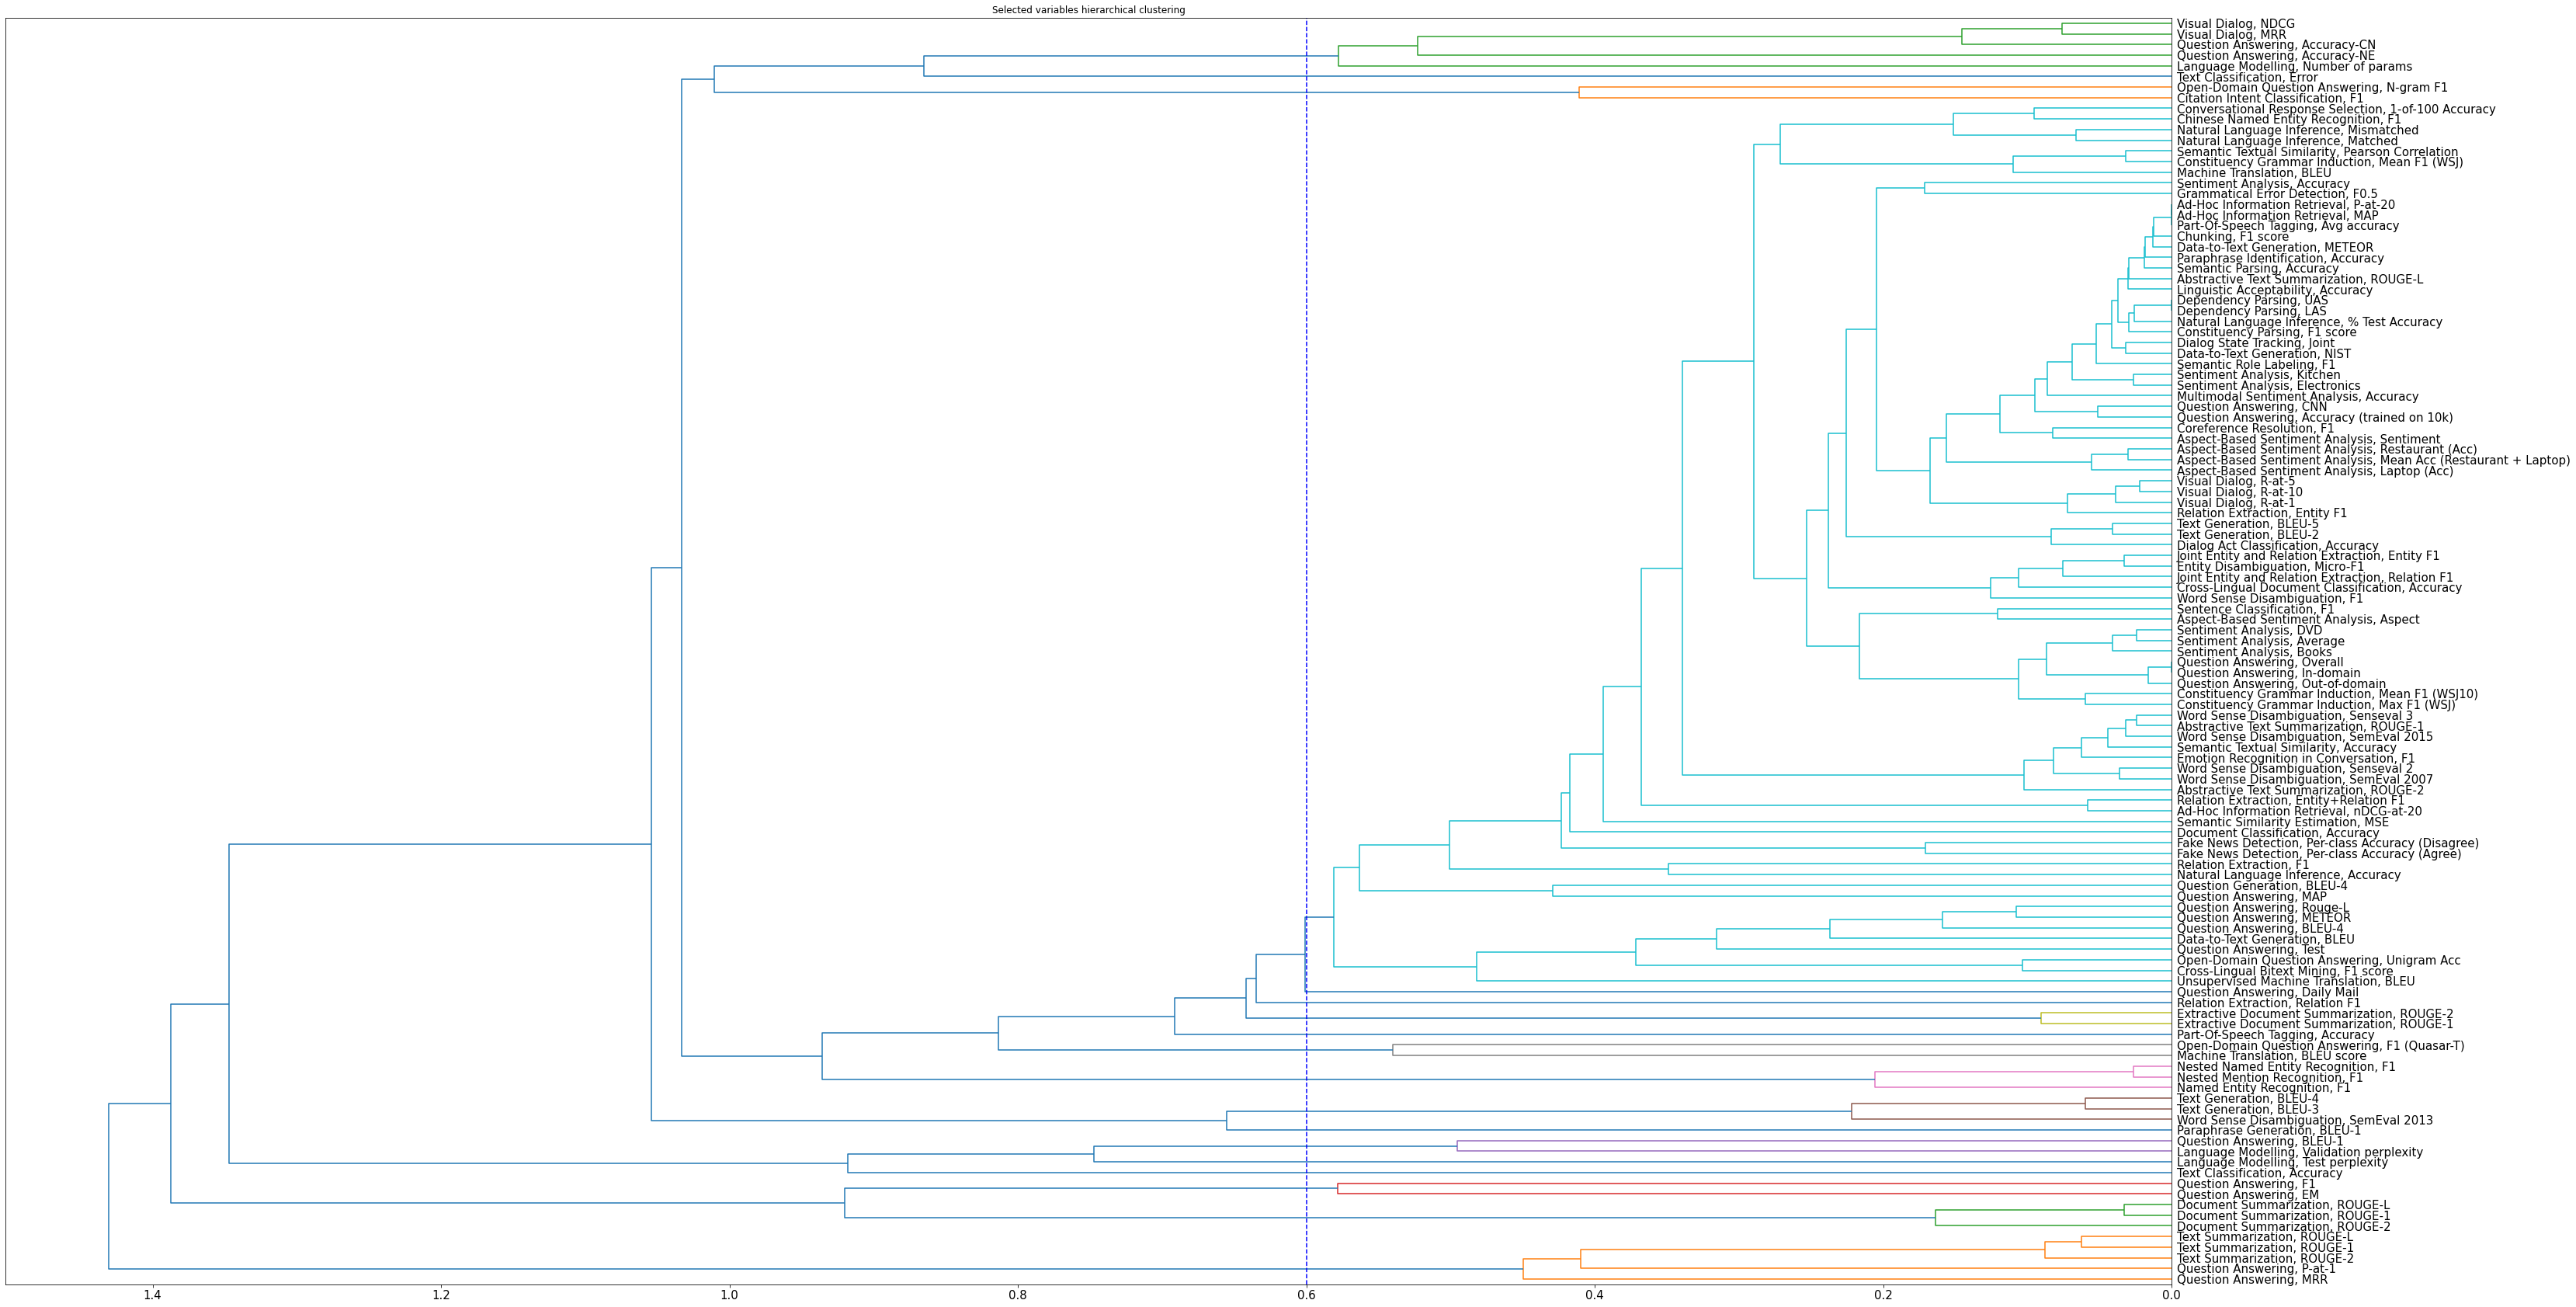

In [46]:
import scipy.cluster.hierarchy as shc

#col_filter="Accuracy,"
#col_filter="F1,|Accuracy,|BLEU,|Recall,|Precision,|BLEU score,"

plt.figure(figsize=(50, 30))  
plt.title("Selected variables hierarchical clustering")  

#cut=400 #for value

cut=0.6 #for percentage

#define inside the regular expression which variable to use for the clustering (unique_vars variable)
dend = shc.dendrogram(shc.linkage(np.array(df[df.columns.intersection(unique_vars)]),method='ward'),
                                 labels=df.index,
                                 orientation='left',
                                 color_threshold=cut)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.axvline(linestyle='--', x=cut, c="Blue") 

#plt.savefig('dend_percent_max_sota.png')
#plt.savefig('dend_percent.png')
#plt.savefig('dend_value.png')
plt.savefig('dend_ratio_unique_task.png')


#Ref:https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

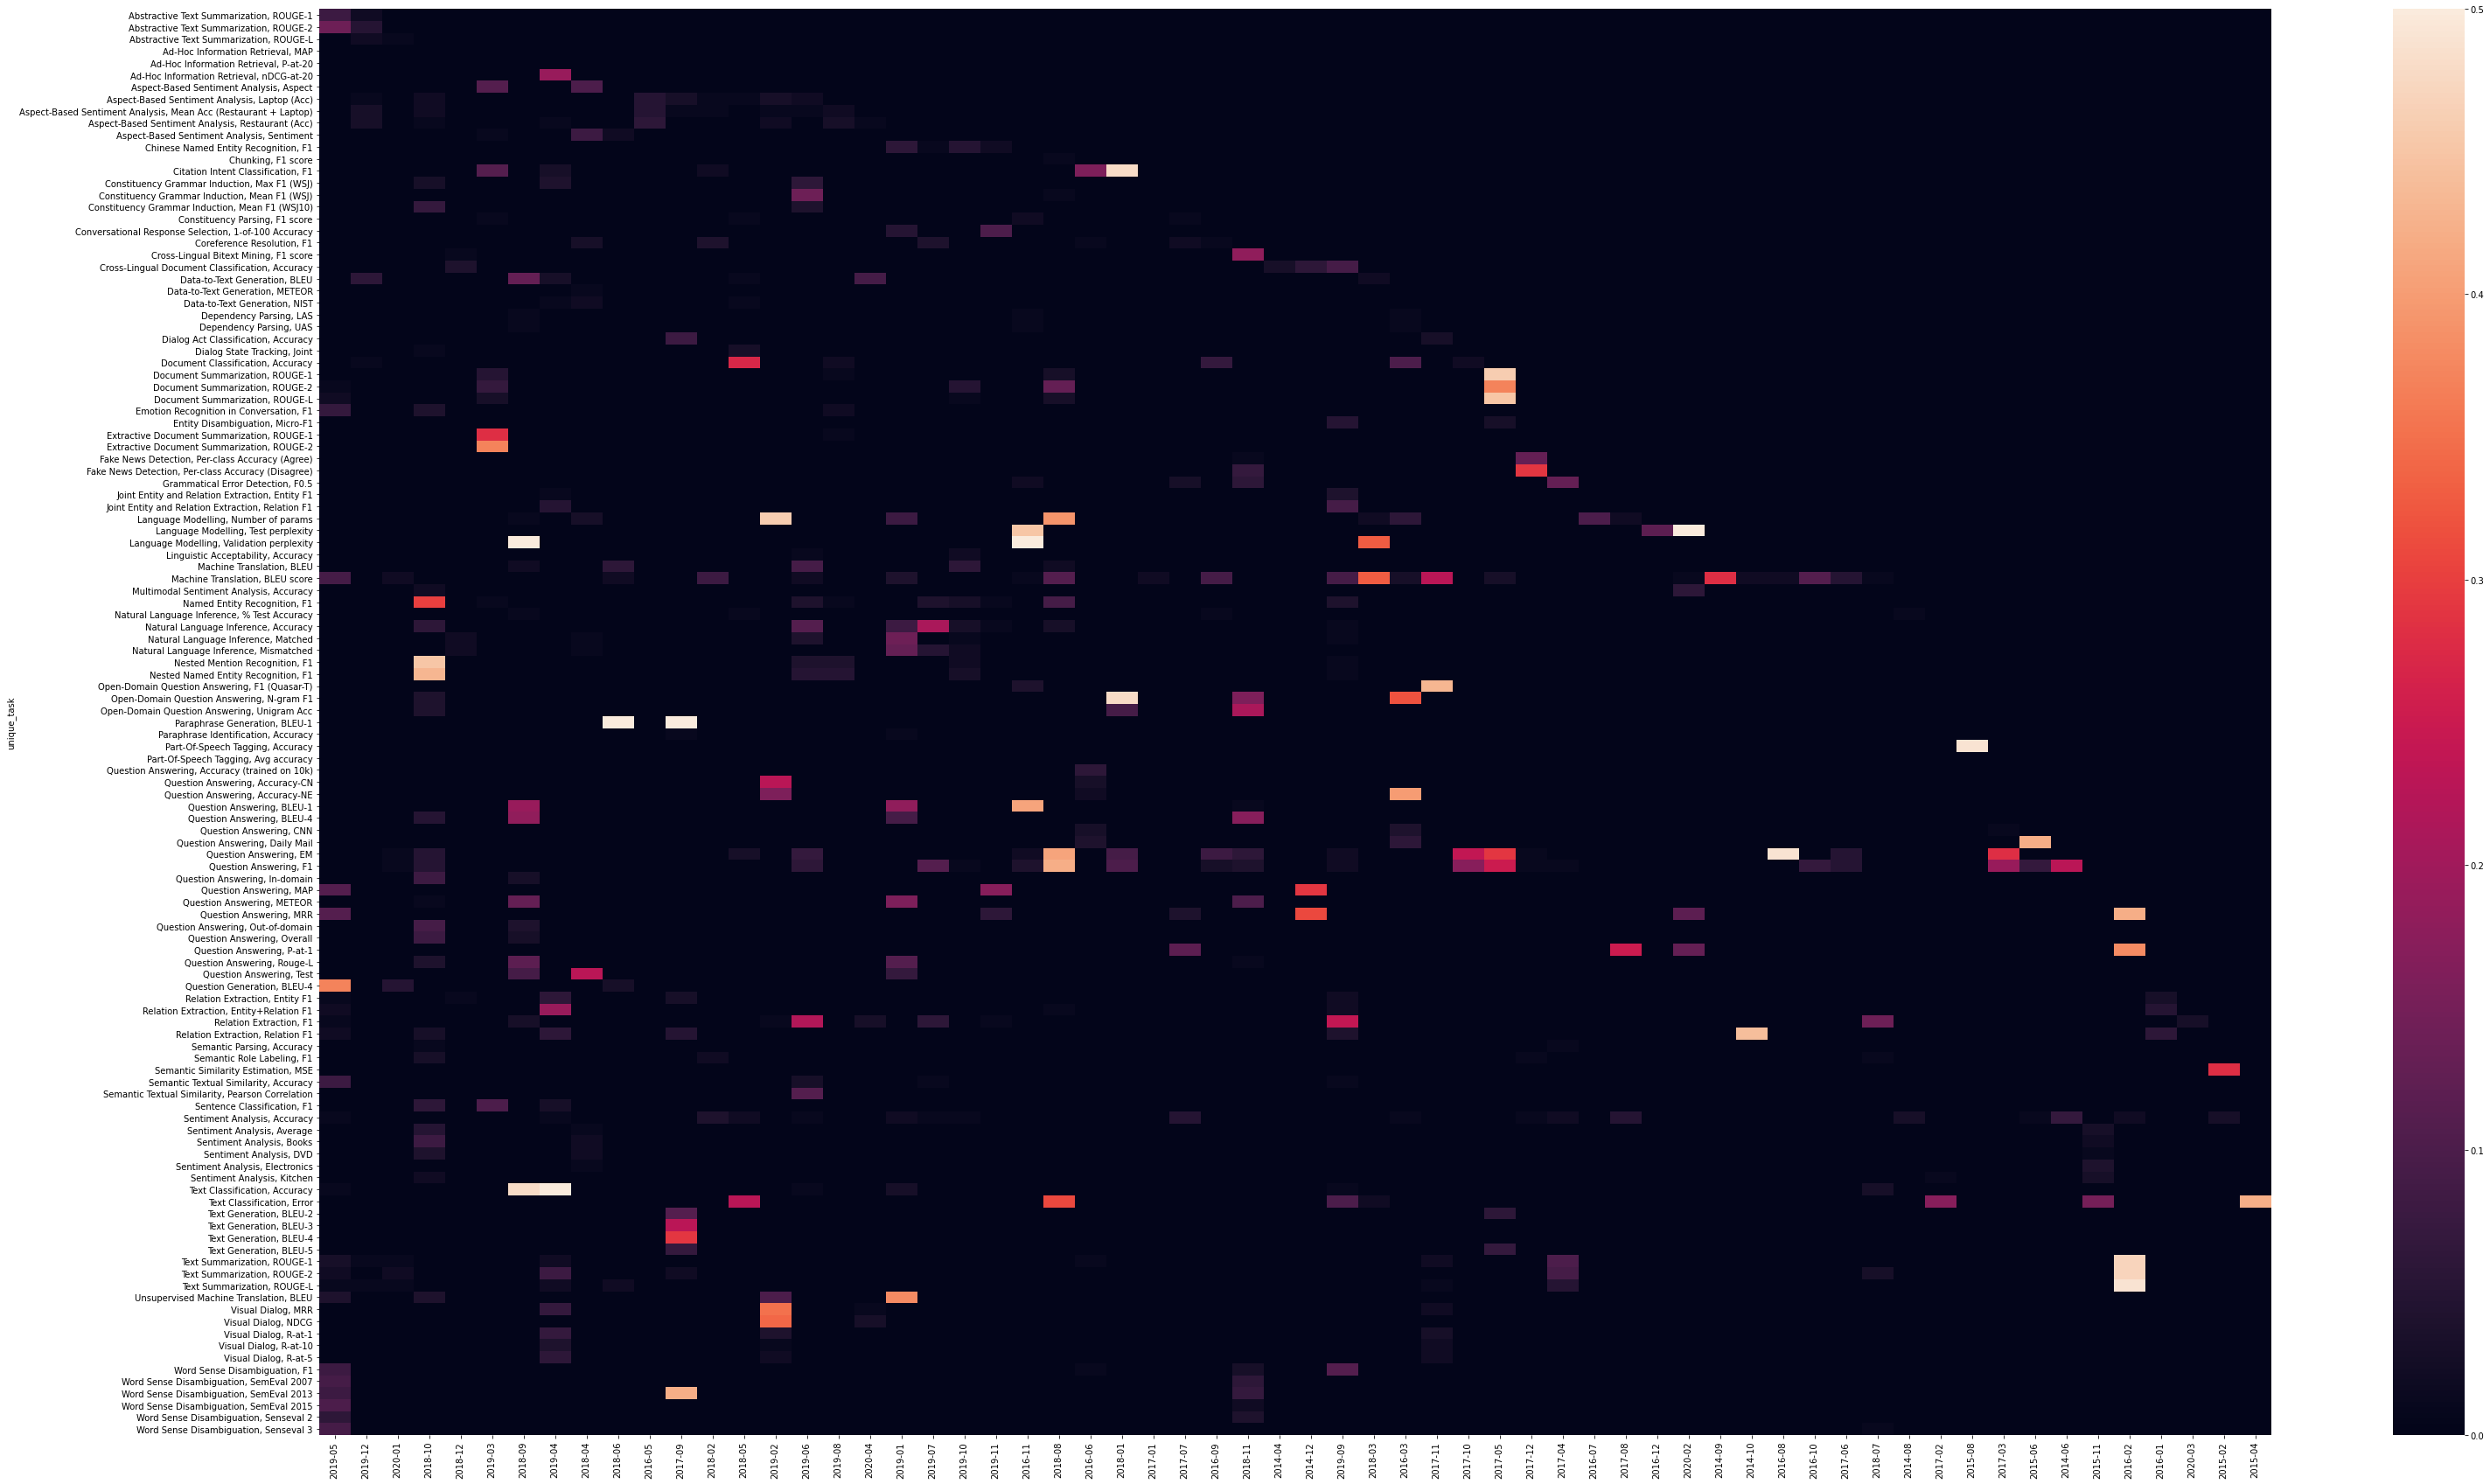

In [47]:
#plot heatmap (better to use clustermap below)
fig, ax = plt.subplots(figsize=(50,30)) 
ax = sns.heatmap(df)
plt.savefig('heat_ratio_unique_task.png')
#Ref:https://seaborn.pydata.org/generated/seaborn.clustermap.html

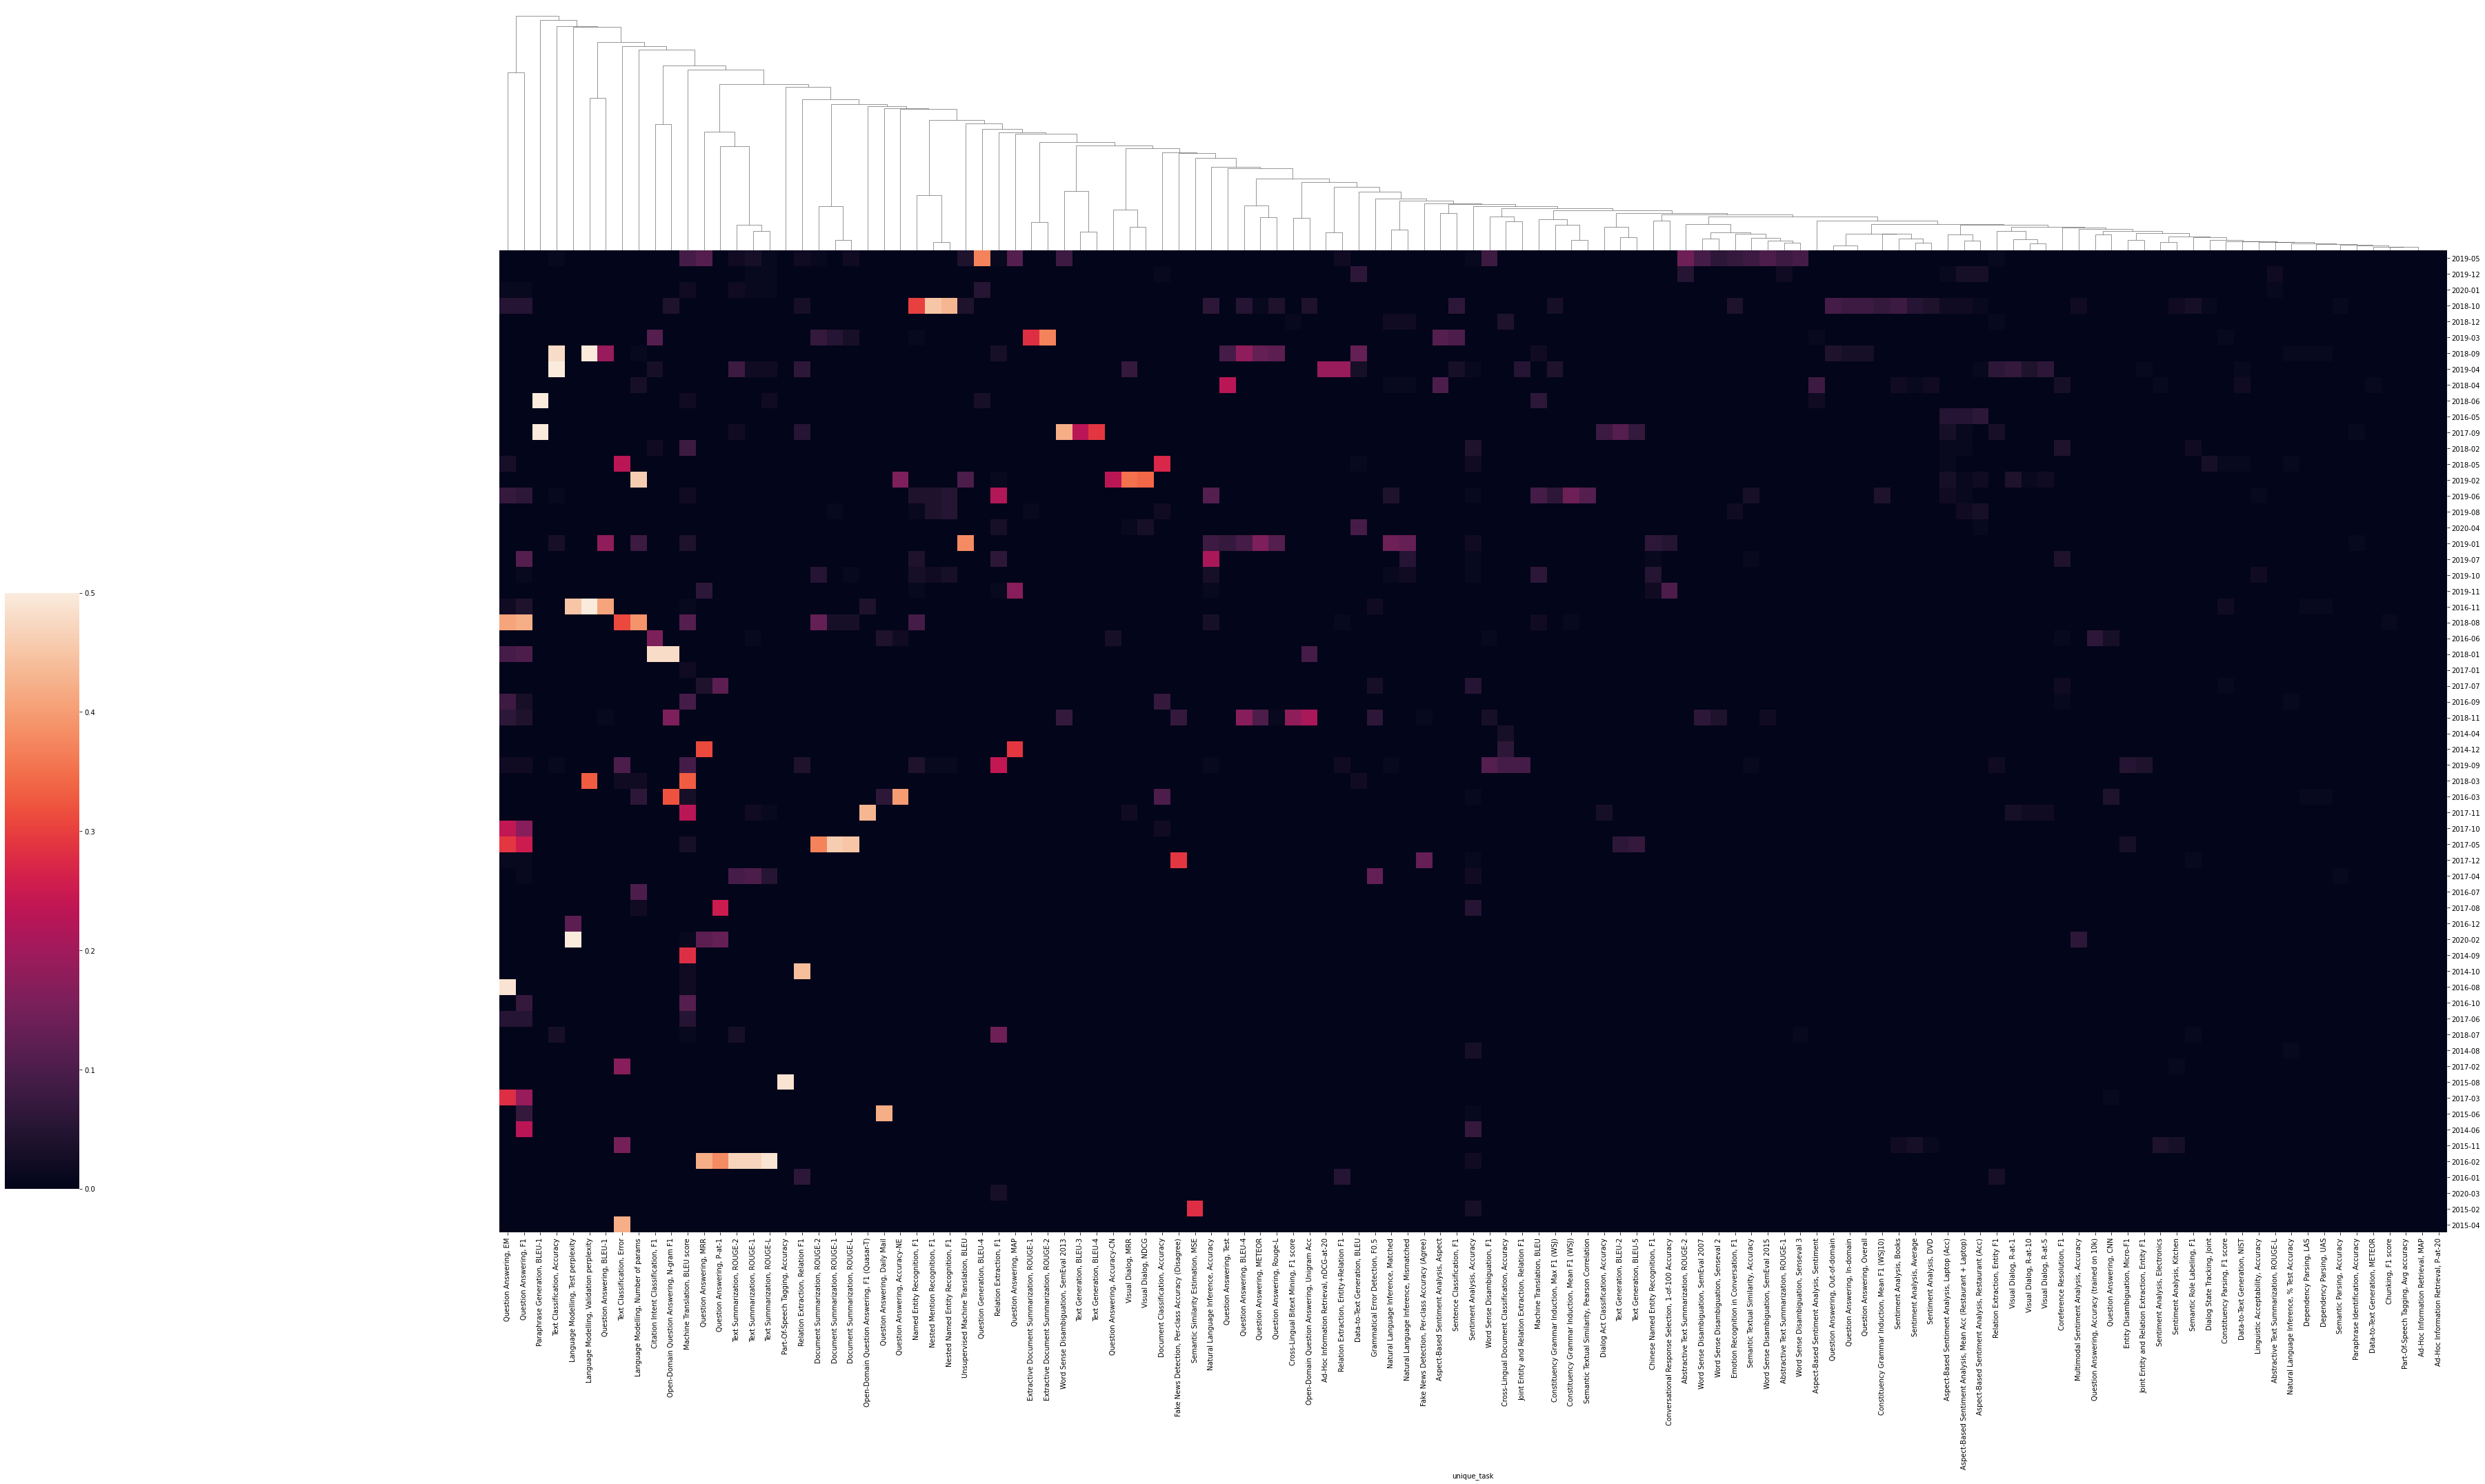

In [48]:
#clustermap showing distance analysis between the tasks
ax = sns.clustermap(df.T,
                    figsize=(50, 30),
                    metric="euclidean",
                    row_cluster=False,
                    #dendrogram_ratio=(.1, .2),
                    cbar_pos=(0, .2, .03, .4))
plt.savefig('clustermap_ratio_unique_task.png')
#Ref:https://seaborn.pydata.org/generated/seaborn.clustermap.html

In [64]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

df

2019-05  2019-12  2020-01  \
unique_task                                                                     
Abstractive Text Summarization, ROUGE-1                0.08     0.02     0.00   
Abstractive Text Summarization, ROUGE-2                0.14     0.05     0.00   
Abstractive Text Summarization, ROUGE-L                0.00     0.02     0.01   
Ad-Hoc Information Retrieval, MAP                      0.00     0.00     0.00   
Ad-Hoc Information Retrieval, P-at-20                  0.00     0.00     0.00   
Ad-Hoc Information Retrieval, nDCG-at-20               0.00     0.00     0.00   
Aspect-Based Sentiment Analysis, Aspect                0.00     0.00     0.00   
Aspect-Based Sentiment Analysis, Laptop (Acc)          0.00     0.01     0.00   
Aspect-Based Sentiment Analysis, Mean Acc (Rest...     0.00     0.03     0.00   
Aspect-Based Sentiment Analysis, Restaurant (Acc)      0.00     0.03     0.00   
Aspect-Based Sentiment Analysis, Sentiment             0.00     0.00     0.00   
Chinese Named Entity Recognition, F1                   0.00     0.00     0.00   
Chunking, F1 score                                     0.00     0.00     0.00   
Citation Intent Classification, F1                     0.00     0.00     0.00   
Constituency Grammar Induction, Max F1 (WSJ)           0.00     0.00     0.00   
Constituency Grammar Induction, Mean F1 (WSJ)          0.00     0.00     0.00   
Constituency Grammar Induction, Mean F1 (WSJ10)        0.00     0.00     0.00   
Constituency Parsing, F1 score                         0.00     0.00     0.00   
Conversational Response Selection, 1-of-100 Acc...     0.00     0.00     0.00   
Coreference Resolution, F1                             0.00     0.00     0.00   
Cross-Lingual Bitext Mining, F1 score                  0.00     0.00     0.00   
Cross-Lingual Document Classification, Accuracy        0.00     0.00     0.00   
Data-to-Text Generation, BLEU                          0.00     0.06     0.00   
Data-to-Text Generation, METEOR                        0.00     0.00     0.00   
Data-to-Text Generation, NIST                          0.00     0.00     0.00   
Dependency Parsing, LAS                                0.00     0.00     0.00   
Dependency Parsing, UAS                                0.00     0.00     0.00   
Dialog Act Classification, Accuracy                    0.00     0.00     0.00   
Dialog State Tracking, Joint                           0.00     0.00     0.00   
Document Classification, Accuracy                      0.00     0.01     0.00   
Document Summarization, ROUGE-1                        0.00     0.00     0.00   
Document Summarization, ROUGE-2                        0.01     0.00     0.00   
Document Summarization, ROUGE-L                        0.02     0.00     0.00   
Emotion Recognition in Conversation, F1                0.07     0.00     0.00   
Entity Disambiguation, Micro-F1                        0.00     0.00     0.00   
Extractive Document Summarization, ROUGE-1             0.00     0.00     0.00   
Extractive Document Summarization, ROUGE-2             0.00     0.00     0.00   
Fake News Detection, Per-class Accuracy (Agree)        0.00     0.00     0.00   
Fake News Detection, Per-class Accuracy (Disagree)     0.00     0.00     0.00   
Grammatical Error Detection, F0.5                      0.00     0.00     0.00   
Joint Entity and Relation Extraction, Entity F1        0.00     0.00     0.00   
Joint Entity and Relation Extraction, Relation F1      0.00     0.00     0.00   
Language Modelling, Number of params                   0.00     0.00     0.00   
Language Modelling, Test perplexity                    0.00     0.00     0.00   
Language Modelling, Validation perplexity              0.00     0.00     0.00   
Linguistic Acceptability, Accuracy                     0.00     0.00     0.00   
Machine Translation, BLEU                              0.00     0.00     0.00   
Machine Translation, BLEU score                        0.09     0.00     0.02   
Mu

ValueError: The condensed distance matrix must contain only finite values.

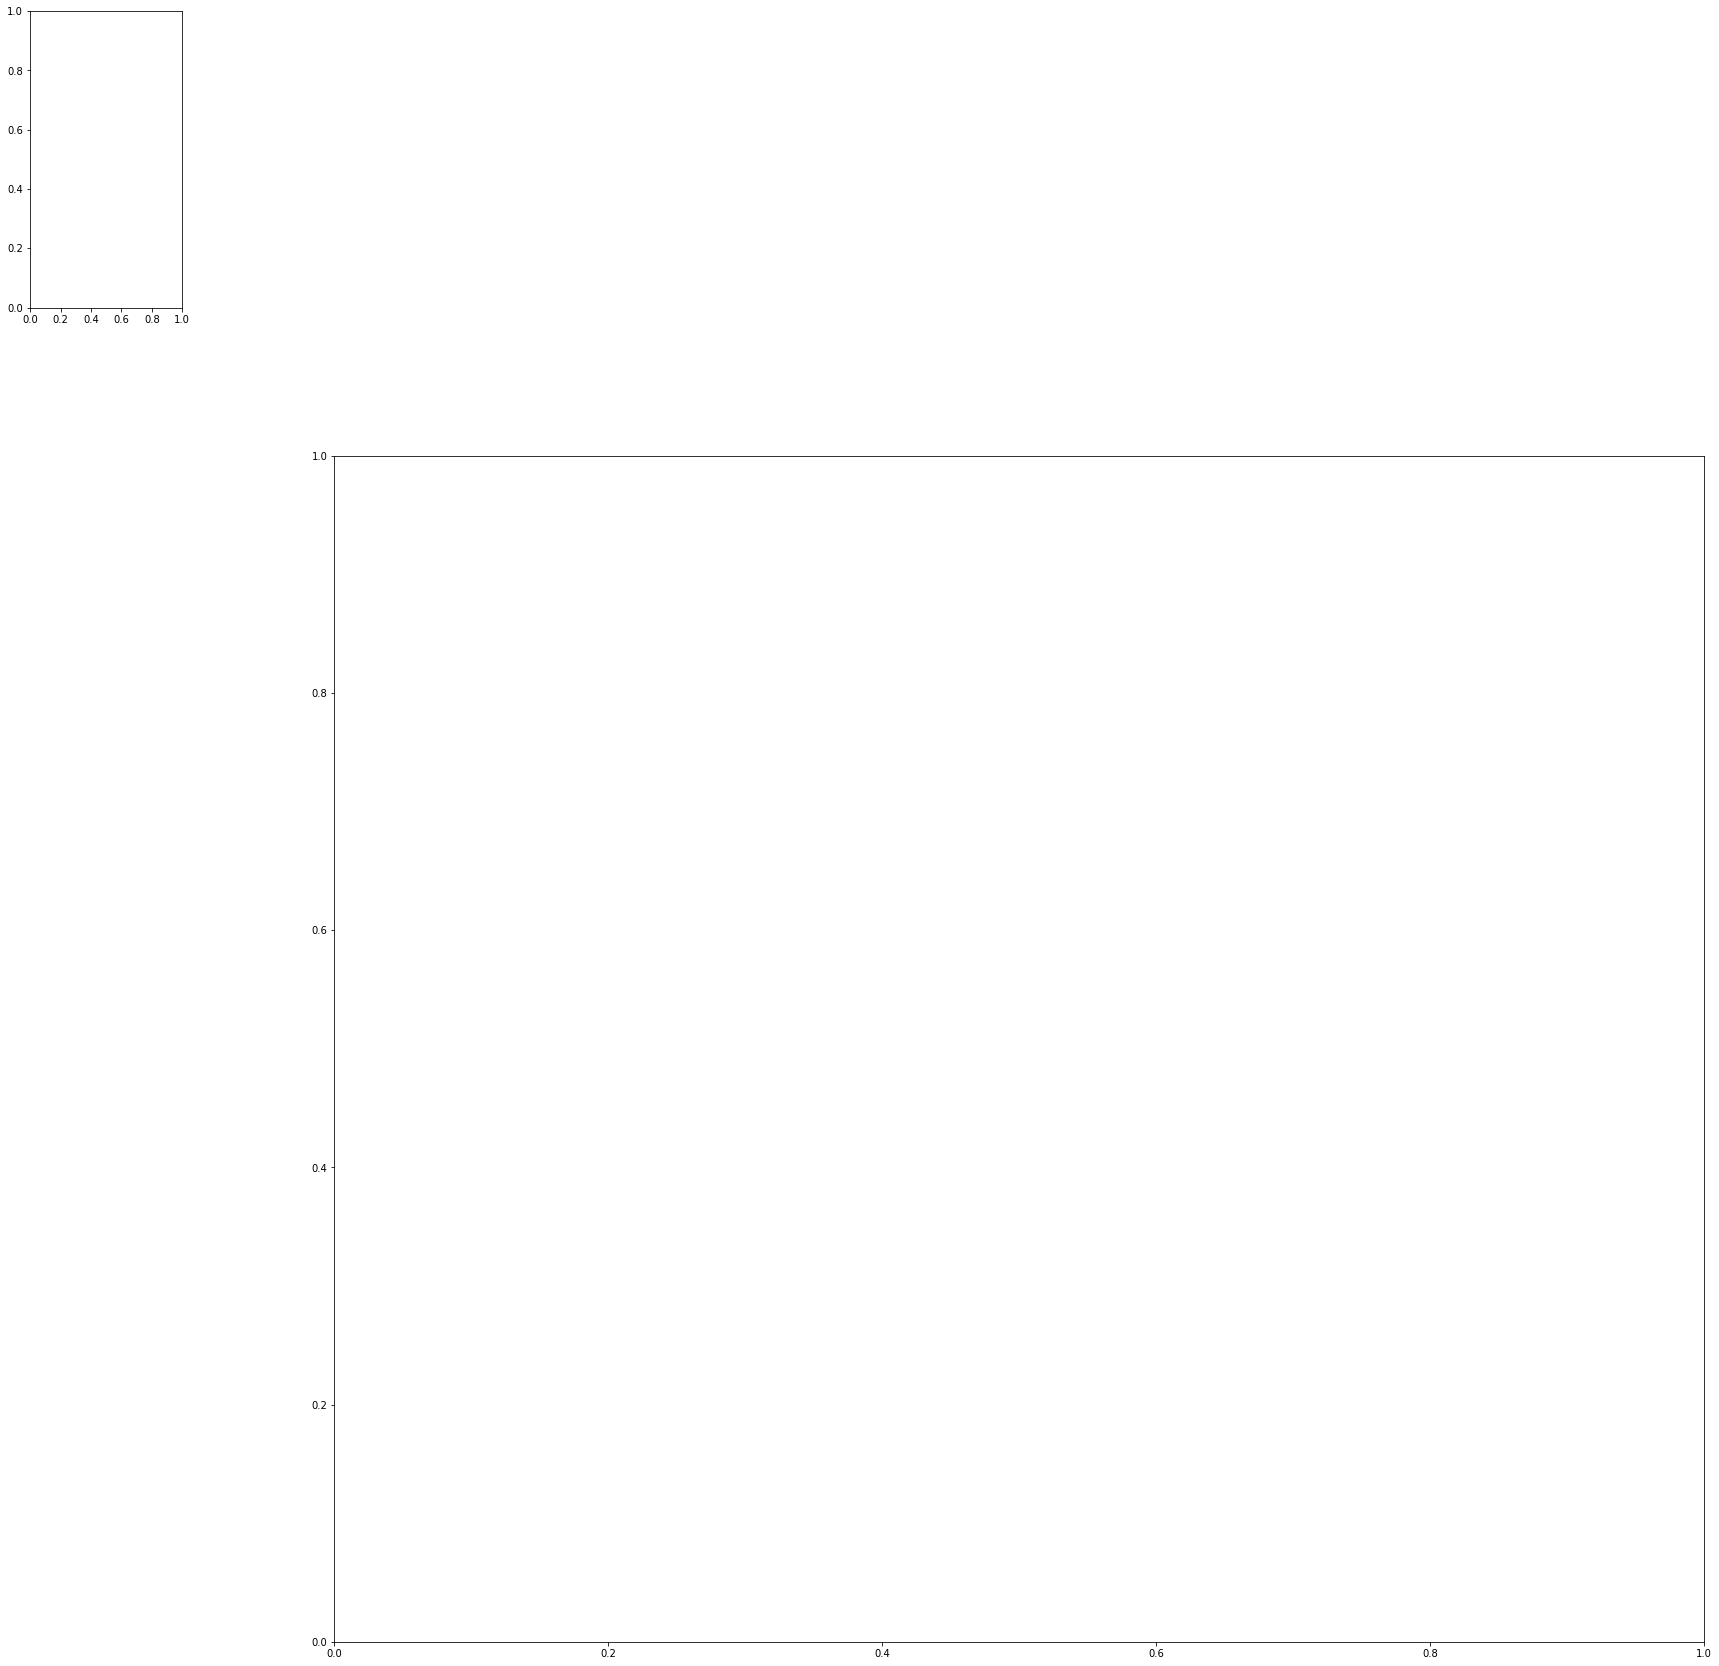

In [58]:
#clustermap showing correlation analysis between the tasks
from matplotlib import rcParams
rcParams['axes.titlepad'] = 1 # Space between the title and graph

ax = sns.clustermap(df,
                    figsize=(30, 30),
                    metric="correlation",
                    col_cluster=False,
                    dendrogram_ratio=(.1, .2),
                    cbar_pos=(-.05, .2, .03, .4)
                    )
plt.suptitle('Tasks correlation') 
plt.savefig('clustermap_corr_unique_task.png')
#Ref:https://seaborn.pydata.org/generated/seaborn.clustermap.html